# **Cross Lingual Eng-Esp Word Embedding Model**

## Students:
1. **Mustafa Mallesho** 222110520
2. **Khaled Suwaine** 219210991
3. **Naif Hazzaa Alrous** 222110926
4. **Hussein Al-Sari** 221110151

## Supervised By :
- **Dr. El Moatez Billah Nagoudi**

## Dataset:
https://opus.nlpl.eu/ELRC-EMEA/en&es/v1/ELRC-EMEA

## Project Objective Statement:
- This project aims to implement and evaluate an English–Spanish bilingual word embedding model using a randomized sentence-level shuffling approach inspired by ArbEngVec. The objective is to train a CBOW-based embedding model on shuffled parallel sentence pairs and evaluate it intrinsically (via word translation accuracy) and extrinsically (via semantic textual similarity using a generated medical dataset - simulating the STS2017 dataset -). The goal is to demonstrate that this alignment-free method can produce competitive bilingual embeddings that capture both semantic equivalence and cross-lingual similarity, using a lightweight and reproducible training pipeline.



Note: Most of insights and conclusions are listed in the ppt presentation

# Run This First - Install Dependencies

In [ ]:
# install only this restart runtime
!pip install --upgrade pip
!pip uninstall -y numpy scipy gensim
!pip install numpy==1.26.4 scipy==1.13.1 gensim==4.3.3
!pip install fasttext
!pip install nltk googletrans==4.0.0-rc1 langdetect
!pip install datasets



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfr

# Dataset Upload and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from gensim.models import Word2Vec,FastText
import random
from transformers import BertModel
import torch
import torch.nn as nn
from transformers import MarianMTModel, MarianTokenizer
import os
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import json



file_path = '/content/drive/MyDrive/es-en.jsonl'

es_list = []
gt_en_list = []  # Ground truth English sentences



input_path = '/content/drive/MyDrive/medical_sts_10000_controlled.jsonl'
output_path = '/content/drive/MyDrive/en_es_sts_eval.tsv'



with open(input_path, 'r', encoding='utf-8') as f_in, open(output_path, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        item = json.loads(line.strip())
        score = item['score']
        sent1 = item['sentence1'] # English
        sent2 = item['sentence2']  # Spanish
        f_out.write(f"{score}\t{sent1}\t{sent2}\n")


file_path = '/content/drive/MyDrive/spanish_words.txt'

spanish = '/content/drive/MyDrive/spanish_words.txt'


with open(file_path, encoding='latin1') as f:
    spanish_vocab = set(line.strip().lower() for line in f)

file_path = '/content/drive/MyDrive/words_alpha.txt'

with open(file_path, encoding='utf-8') as f:
    english_vocab = set(line.strip().lower() for line in f)

save_path = "/content/drive/MyDrive/embedding_models"
os.makedirs(save_path, exist_ok=True)


# Load data
en = '/content/drive/MyDrive/en-es.txt/ELRC-EMEA.en-es.en'
es = '/content/drive/MyDrive/en-es.txt/ELRC-EMEA.en-es.es'

with open(en, 'r', encoding='utf-8') as f:
    EN = f.readlines()
with open(es, 'r', encoding='utf-8') as f:
    ES = f.readlines()


EN_tokenized = [word_tokenize(sent.lower()) for sent in gt_en_list]
ES_tokenized = [word_tokenize(sent.lower()) for sent in es_list]

# Preprocess and shuffle word_en
combined_sentences = [e.strip().split() + s.strip().split() for e, s in zip(EN, ES)]
shuffled_tokens_sentences = [random.sample(sentence, len(sentence)) for sentence in combined_sentences]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# OLD SENTENCE EVALUTATION

In [ ]:
import nltk

from nltk.tokenize import word_tokenize

# Tokenize English sentences
nltk.download('all')

EN_tokenized = [word_tokenize(sentence.lower()) for sentence in EN]
ES_tokenized = [word_tokenize(sentence.lower()) for sentence in ES]

model_path = "/content/drive/MyDrive/embedding_models"
cbow_model = Word2Vec.load(f"{model_path}/cbow_word2vec.model")
import numpy as np

def get_sentence_vector(sentence_tokens, model):
    vectors = [model.wv[word] for word in sentence_tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
from sklearn.metrics.pairwise import cosine_similarity

vec1 = get_sentence_vector(EN_tokenized[0], cbow_model)
vec2 = get_sentence_vector(ES_tokenized[0], cbow_model)

similarity = cosine_similarity([vec1], [vec2])[0][0]
print("Cosine Similarity:", similarity)



[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to get sentence vector
def get_sentence_vector(sentence_tokens, model):
    vectors = [model.wv[word] for word in sentence_tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Compare first 10 EN–ES pairs
for i in range(10):
    vec_en = get_sentence_vector(EN_tokenized[i], cbow_model)
    vec_es = get_sentence_vector(ES_tokenized[i], cbow_model)
    sim = cosine_similarity([vec_en], [vec_es])[0][0]
    print(f"Sentence {i+1}: Cosine Similarity = {sim:.4f}")


Sentence 1: Cosine Similarity = 0.7907
Sentence 2: Cosine Similarity = 0.8530
Sentence 3: Cosine Similarity = 0.9297
Sentence 4: Cosine Similarity = 0.9386
Sentence 5: Cosine Similarity = 0.9135
Sentence 6: Cosine Similarity = 0.8842
Sentence 7: Cosine Similarity = 0.8933
Sentence 8: Cosine Similarity = 0.9157
Sentence 9: Cosine Similarity = 0.9317
Sentence 10: Cosine Similarity = 0.9256


#CBOW W2V - Training

In [ ]:
######## CBOW #############

cbow_model = Word2Vec(
    sentences=shuffled_tokens_sentences,
    vector_size=300,
    window=5,
    min_count=5,
    sg=0,
    epochs=3
)

cbow_model.save("cbow_word2vec.model")

#SKIPGRAM W2V - Training

In [ ]:
########SKIPGRAM #############

skipgram_model = Word2Vec(
    sentences=shuffled_tokens_sentences,
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,
    negative=5,
    epochs=3
)
skipgram_model.save("skipgram_word2vec.model")


#CBOW character-level - Training

In [ ]:
########CBOW character-level #############

cbow_ft = FastText(
    sentences=shuffled_tokens_sentences,
    vector_size=300,
    window=5,
    min_count=5,
    sg=0,
    epochs=3
)

cbow_ft.save("cbow_fasttext.model")




#SKIPGRAM character-level - Training

In [ ]:
########CBOW character-level #############

cbow_ft = FastText(
    sentences=shuffled_tokens_sentences,
    vector_size=300,
    window=5,
    min_count=5,
    sg=0,
    epochs=3
)

cbow_ft.save("cbow_fasttext.model")



#Loading Models from Drive

In [ ]:
model_path = "/content/drive/MyDrive/embedding_models"
cbow_model = Word2Vec.load(f"{model_path}/cbow_word2vec.model")
skipgram_model = Word2Vec.load(f"{model_path}/skipgram_word2vec.model")
# FastText
cbow_ft = FastText.load(f"{model_path}/cbow_fasttext.model")
skipgram_ft = FastText.load(f"{model_path}/skipgram_fasttext.model")


# Quick Test

In [ ]:

model_name = "Helsinki-NLP/opus-mt-en-es"
tokenizer = MarianTokenizer.from_pretrained(model_name)
Translator = MarianMTModel.from_pretrained(model_name)


text = 'bacteria'

inputs = tokenizer(text, return_tensors="pt", padding=True)
outputs = Translator.generate(**inputs)
translated = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Translated:", translated)

word = text

print("CBOW Word2Vec:")
print(cbow_model.wv.most_similar([word], topn=5))
print('########################')

print("Skipgram Word2Vec:")
print(skipgram_model.wv.most_similar([word], topn=5))
print('########################')

print("CBOW FastText:")
print(cbow_ft.wv.most_similar([word], topn=5))
print('########################')

print("Skipgram FastText:")
print(skipgram_ft.wv.most_similar([word], topn=5))

Translated: bacterias
CBOW Word2Vec:
[('bacterias', 0.9593488574028015), ('virus.', 0.9061993360519409), ("body's", 0.886323094367981), ('inmunitario', 0.8854122757911682), ('viruses', 0.8783985376358032)]
########################
Skipgram Word2Vec:
[('bacterias', 0.8491947054862976), ('bacteria,', 0.7821919322013855), ('bacteria.', 0.7650184631347656), ('bacterium', 0.7377668023109436), ('bacterias.', 0.7270734310150146)]
########################
CBOW FastText:
[("bacteria's", 0.9812614321708679), ('(bacteria', 0.9792258739471436), ('bacteria:', 0.9758450388908386), ('bacteriano', 0.9692854285240173), ('cyanobacteria', 0.9664652943611145)]
########################
Skipgram FastText:
[("bacteria's", 0.9698164463043213), ('bacterias', 0.9622278809547424), ('(bacteria', 0.9521452188491821), ('bacterium', 0.9399193525314331), ('bacteria:', 0.9363365769386292)]


#MODEL EVALUTATION GOOGLE VERSION (OLD)



In [ ]:
import numpy as np
import string
from googletrans import Translator

# ✅ Clean function
def clean(word):
    return word.lower().translate(str.maketrans('', '', string.punctuation))

# ✅ Medical word list
medical_words = [
    'fever', 'diabetes', 'asthma', 'cancer', 'tumor', 'surgery', 'vaccine', 'infection', 'virus', 'bacteria',
    'pain', 'nausea', 'headache', 'cough', 'antibiotic', 'therapy', 'prescription', 'allergy', 'hospital', 'nurse',
]

result_vector = np.zeros(len(medical_words))
translator = Translator()

# ✅ Back translation logic
for idx, word in enumerate(medical_words):
    try:
        es = translator.translate(word, src='en', dest='es').text
        back = translator.translate(es, src='es', dest='en').text
        print(f"🔁 {word} → {es} → {back}")

        if clean(back) == clean(word):
            result_vector[idx] = 1
            print(f"✅ Match: {clean(back)} == {clean(word)}")

    except Exception as e:
        print(f"❌ Error on '{word}':", e)

print("\n✅ Final binary vector:")
print(result_vector)


🔁 fever → fiebre → fever
✅ Match: fever == fever
🔁 diabetes → diabetes → diabetes
✅ Match: diabetes == diabetes
🔁 asthma → asma → asthma
✅ Match: asthma == asthma
🔁 cancer → cáncer → cancer
✅ Match: cancer == cancer
🔁 tumor → tumor → tumor
✅ Match: tumor == tumor
🔁 surgery → cirugía → surgery
✅ Match: surgery == surgery
🔁 vaccine → vacuna → vaccine
✅ Match: vaccine == vaccine
🔁 infection → infección → infection
✅ Match: infection == infection
🔁 virus → virus → virus
✅ Match: virus == virus
🔁 bacteria → bacterias → bacteria
✅ Match: bacteria == bacteria
🔁 pain → dolor → pain
✅ Match: pain == pain
🔁 nausea → náuseas → nausea
✅ Match: nausea == nausea
🔁 headache → dolor de cabeza → headache
✅ Match: headache == headache
🔁 cough → tos → cough
✅ Match: cough == cough
❌ Error on 'antibiotic': 'NoneType' object is not iterable
🔁 therapy → terapia → therapy
✅ Match: therapy == therapy
🔁 prescription → prescripción → prescription
✅ Match: prescription == prescription
🔁 allergy → alergia → aller

#CBOW W2V word by word EVALUATION

In [ ]:
import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import numpy as np

model = cbow_model

# 2. Define 200 medical words (example placeholder list)
medical_words = [
    "abdomen", "abdominal", "abortion", "abscess", "absorption", "abuse", "acetaminophen", "acetylcholine", "achilles", "acidosis",
    "acne", "acoustic", "acquired", "acromegaly", "actin", "acupuncture", "acute", "adaptation", "addiction", "adduction",
    "adenocarcinoma", "adenoids", "adenoma", "adhesion", "adipose", "adjuvant", "adrenal", "adrenaline", "adrenergic", "adrenocortical",
    "aerobic", "afebrile", "afferent", "agglutination", "agnosia", "agonist", "agoraphobia", "airway", "alanine", "albumin",
    "albuminuria", "alcohol", "aldosterone", "alimentary", "alkaline", "alkalosis", "allergen", "allergy", "alopecia", "alpha",
    "alveolar", "alveoli", "alzheimer", "amblyopia", "amenorrhea", "amino", "amnesia", "amniocentesis", "amniotic", "amoeba",
    "amphetamine", "amputation", "amylase", "amyloid", "anabolic", "anaerobic", "analgesia", "analgesic", "anaphylaxis", "anastomosis",
    "anatomical", "anatomy", "androgen", "anemia", "anesthesia", "anesthetic", "aneurysm", "angina", "angiogenesis", "angiography",
    "angioplasty", "angiotensin", "anomaly", "anorexia", "anosmia", "anoxia", "antagonist", "anterior", "antibiotic", "antibody",
    "anticoagulant", "anticonvulsant", "antidepressant", "antidiuretic", "antigen", "antihistamine", "antihypertensive", "antimicrobial", "antineoplastic", "antioxidant",
    "antiseptic", "antitoxin", "antiviral", "anuria", "anus", "aorta", "aortic", "apex", "aphasia", "apnea",
    "apoptosis", "appendectomy", "appendicitis", "appendix", "appetite", "arachnoid", "arrhythmia", "arterial", "arteriogram", "arteriole",
    "arteriosclerosis", "artery", "arthralgia", "arthritis", "arthrocentesis", "arthrodesis", "arthroplasty", "arthroscopy", "articulation", "artificial",
    "ascites", "aseptic", "asphyxia", "aspiration", "aspirin", "asthma", "astigmatism", "astrocyte", "ataxia", "atelectasis",
    "atherectomy", "atherosclerosis", "atopic", "atopy", "atrial", "atrioventricular", "atrium", "atrophy", "auscultation", "autism",
    "autoimmune", "autonomic", "autopsy", "avulsion", "axilla", "axon", "azotemia", "bacteremia", "bacteria", "bacteriology",
    "bariatric", "barium", "barotrauma", "basal", "basophil", "beta", "biceps", "bicuspid", "bifurcation", "bilateral",
    "bile", "biliary", "bilirubin", "biofeedback", "biopsy", "biotin", "bipolar", "bladder", "blastocyst", "blepharitis",
    "blepharoplasty", "blood", "bolus", "bone", "borborygmi", "botulism", "bowel", "brachial", "brachytherapy", "bradycardia",
    "bradykinesia", "brain", "brainstem", "bronchi", "bronchial", "bronchiectasis", "bronchiole", "bronchiolitis", "bronchitis", "bronchodilator",
    "bronchoscopy", "bruxism", "buccal", "bulimia", "bunion", "bursa", "bursitis", "bypass", "cachexia", "calcification",
    "calcitonin", "calcium", "calculus", "callus", "calorie", "canaliculi", "cancer", "candida", "canine", "cannula",
    "capillary", "capsule", "carbohydrate", "carcinogen", "carcinoma", "cardiac", "cardiology", "cardiopulmonary", "cardiovascular", "caries",
    "carotid", "carpal", "cartilage", "cataract", "catheter", "caudal", "cauterization", "cecum", "celiac", "cellulitis",
    "cephalic", "cerebellum", "cerebral", "cerebrospinal", "cerebrovascular", "cerumen", "cervical", "cervix", "cesarean", "chalazion",
    "chemoreceptor", "chemotherapy", "cholangitis", "cholecystectomy", "cholecystitis", "choledocholithiasis", "choledochostomy", "cholelithiasis", "cholera", "cholesterol",
    "chondrocyte", "chorionic", "choroid", "chromatin", "chromosome", "chronic", "chyme", "cicatrix", "ciliary", "circadian",
    "circulation", "circulatory", "circumcision", "cirrhosis", "claudication", "clavicle", "cleft", "clinical", "clitoris", "clonus",
    "coagulation", "cochlea", "cochlear", "cognition", "cognitive", "colectomy", "colic", "colitis", "collagen", "collapse",
    "collateral", "colon", "colonoscopy", "colostomy", "colostrum", "coma", "comminuted", "commissure", "communicable", "comorbidity",
    "compartment", "compensation", "complement", "complex", "compliance", "compress", "compression", "concussion", "condom", "conduction",
    "condyle", "condyloma", "congenital", "congestion", "congestive", "conjunctiva", "conjunctivitis", "connective", "consciousness", "constipation",
    "consultation", "contraction", "contraindication", "contusion", "convulsion", "copulation", "cordocentesis", "cornea", "coronal", "coronary",
    "coronavirus", "corpora", "corpus", "cortex", "cortical", "corticosteroid", "cortisol", "costal", "cough", "coumadin",
    "countershock", "crackle", "cranial", "craniotomy", "creatine", "creatinine", "crepitus", "cretinism", "cribriform", "cricoid",
    "crisis", "crohn", "crossmatch", "cryosurgery", "cryotherapy", "cryptorchidism", "crystallization", "culture", "curettage", "cushing",
    "cutaneous", "cyanosis", "cyclothymia", "cyst", "cystic", "cystitis", "cystoscopy", "cytokine", "cytology", "cytoplasm",
    "cytotoxic", "dacryocystitis", "dacryostenosis", "deafness", "debridement", "decubitus", "defecation", "defibrillation", "defibrillator", "deformity",
    "degeneration", "deglutition", "dehiscence", "dehydration", "delirium", "deltoid", "delusion", "dementia", "dendrite", "dental",
    "dentist", "denture", "deoxygenated", "depolarization", "depression", "dermal", "dermatitis", "dermatology", "dermatome", "dermis",
    "detoxification", "diabetes", "diagnosis", "diagnostic", "dialysis", "diaphoresis", "diaphragm", "diaphysis", "diarrhea", "diastole",
    "diastolic", "diathermy", "diencephalon", "dietary", "diffusion", "digestion", "digestive", "digital", "digoxin", "dilatation",
    "dilation", "dilator", "diopter", "diplopia", "disability", "disc", "discectomy", "discharge", "disease", "dislocation",
    "dissection", "distal", "diuresis", "diuretic", "diverticulitis", "diverticulosis", "diverticulum", "dizziness", "dopamine", "doppler",
    "dorsal", "dorsalis", "dosage", "double", "douche", "drainage", "droplet", "drug", "duct", "ductus",
    "duodenal", "duodenum", "dura", "dwarfism", "dysarthria", "dyskinesia", "dyslexia", "dysmenorrhea", "dyspareunia", "dyspepsia",
    "dysphagia", "dysphasia", "dysplasia", "dyspnea", "dysrhythmia", "dystocia", "dystonia", "dystrophy", "dysuria", "eardrum",
    "ecchymosis", "echocardiography", "eclampsia", "ectopic", "eczema", "edema", "efferent", "effusion", "ejaculation", "elastin",
    "electrocardiogram", "electroencephalogram", "electrolyte", "electromyography", "embolectomy", "embolism", "embolus", "embryo", "emergency", "emesis",
    "emetic", "emission", "emphysema", "empyema", "encephalitis", "encephalopathy", "endarterectomy", "endemic", "endocarditis", "endocardium",
    "endocrine", "endocrinology", "endolymph", "endometriosis", "endometrium", "endorphin", "endoscope", "endoscopy", "endothelium", "endotracheal",
    "enema", "energy", "enteral", "enteritis", "enterocolitis", "enterostomy", "enucleation", "enuresis", "enzyme", "eosinophil",
    "ependyma", "epididymis", "epididymitis", "epidural", "epiglottis", "epilepsy", "epinephrine", "epiphysis", "episiotomy", "epistaxis",
    "epithelium", "equilibrium", "erectile", "erection", "ergonomics", "erosion", "erythema", "erythroblastosis", "erythrocyte", "erythropoietin",
    "eschar", "esophageal", "esophagitis", "esophagus", "estrogen", "etiology", "eustachian", "euthyroid", "eversion", "evisceration",
    "exacerbation", "exanthem", "excision", "excoriation", "excretion", "exfoliation", "exhalation", "exocrine", "exophthalmos", "exostosis",
    "expectorant", "expectoration", "expiration", "expiratory", "extension", "extensor", "external", "extracellular", "extracorporeal", "extravasation",
    "extremity", "exudate", "eyebrow", "eyelid", "facet", "facial", "fallopian", "fascia", "fasciculation", "fasciotomy",
    "fasting", "fat", "fatigue", "fauces", "febrile", "fecal", "feces", "femoral", "femur", "fertilization",
    "fetal", "fetoscopy", "fetus", "fever", "fiber", "fibril", "fibrillation", "fibrin", "fibrinogen", "fibroblast",
    "fibrocystic", "fibroids", "fibroma", "fibromyalgia", "fibrosis", "fibrous", "fibula", "fissure", "fistula", "fixation",
    "flaccid", "flagella", "flatulence", "flexion", "flexor", "flora", "fluid", "fluoroscopy", "follicle", "fontanelle",
    "foramen", "forceps", "formication", "fossa", "fovea", "fracture", "fremitus", "frequency", "frontal", "frostbite",
    "fundus", "fungal", "fungus", "furunculosis", "gait", "galactorrhea", "gallbladder", "gallstone", "gamete", "gamma",
    "ganglion", "gangrene", "gastralgia", "gastrectomy", "gastric", "gastritis", "gastroenteritis", "gastroenterology", "gastroesophageal", "gastrointestinal",
    "gastroparesis", "gastroscopy", "gavage", "gene", "genetic", "genital", "genitalia", "genitourinary", "genome", "genu",
    "geriatric", "gestation", "giardiasis", "gigantism", "gingiva", "gingivitis", "gland", "glandular", "glaucoma", "glial",
    "glioma", "globulin", "glomerular", "glomerulonephritis", "glomerulus", "glossitis", "glottis", "glucagon", "glucocorticoid", "glucose",
    "glycogen", "glycolysis", "glycosuria", "goiter", "gonorrhea", "gout", "graft", "granulation", "granuloma", "granulocyte",
    "granulopoiesis", "gravid", "gravida", "gynecology", "gynecomastia", "hallucination", "hallux", "hamartoma", "hamstring", "haploid",
    "healing", "hearing", "heart", "hemangioma", "hematemesis", "hematocrit", "hematology", "hematoma", "hematopoiesis", "hematuria",
    "hemiparesis", "hemiplegia", "hemodialysis", "hemoglobin", "hemolysis", "hemophilia", "hemoptysis", "hemorrhage", "hemorrhagic", "hemorrhoidectomy",
    "hemorrhoids", "hemostasis", "hemothorax", "heparin", "hepatic", "hepatitis", "hepatomegaly", "hepatotoxic", "hereditary", "hernia",
    "herniorrhaphy", "herpes", "heterograft", "hiatus", "hiccup", "hilum", "hippocampus", "hirsutism", "histamine", "histiocyte",
    "histology", "histone", "history", "hives", "homeostasis", "homograft", "hormone", "hospice", "hospital", "humectant",
    "humeral", "humerus", "humor", "hyaline", "hydration", "hydrocele", "hydrocephalus", "hydrogen", "hydronephrosis", "hydroureter",
    "hydroxyl", "hygiene", "hymen", "hyoid", "hyperalimentation", "hypercalcemia", "hypercapnia", "hyperemia", "hyperesthesia", "hyperglycemia",
    "hypergonadism", "hyperkalemia", "hyperlipidemia", "hyperparathyroidism", "hyperplasia", "hyperpnea", "hyperpyrexia", "hyperreflexia", "hypersensitivity", "hypertension",
    "hyperthermia", "hyperthyroidism", "hypertonic", "hypertrophy", "hyperventilation", "hypervolemia", "hypnotic", "hypocalcemia", "hypochondriasis", "hypogastric",
    "hypoglossal", "hypoglycemia", "hypogonadism", "hypokalemia", "hyponatremia", "hypoparathyroidism", "hypophysectomy", "hypophysis", "hypoplasia", "hypoproteinemia",
    "hypotension", "hypothalamus", "hypothermia", "hypothyroidism", "hypotonic", "hypoventilation", "hypovolemia", "hypoxemia", "hypoxia", "hysterectomy",
    "hysterosalpingography", "hysteroscopy", "iatrogenic", "icterus", "ictus", "idiopathic", "ileitis", "ileostomy", "ileum", "ileus",
    "iliac", "ilium", "immunity", "immunization", "immunoassay", "immunodeficiency", "immunoglobulin", "immunology", "immunosuppression", "immunotherapy",
    "impaction", "impetigo", "implantation", "impotence", "incision", "incontinence", "incubation", "incus", "indigestion", "induction",
    "infarction", "infection", "infectious", "infertility", "inflammation", "inflammatory", "inflation", "influenza", "infusion", "ingestion",
    "inguinal", "inhalation", "injection", "innervation", "inoculation", "insemination", "insertion", "insomnia", "inspection", "inspiration",
    "insufficiency", "insufflation", "insulin", "integumentary", "intercostal", "interferon", "interleukin", "internal", "interstitial", "intervertebral",
    "intestinal", "intestine", "intoxication", "intracellular", "intracranial", "intractable", "intramuscular", "intraocular", "intravenous", "intrinsic",
    "intubation", "intussusception", "invasion", "inversion", "involuntary", "iodine", "ipsilateral", "iris", "iritis", "ischemia",
    "ischial", "ischium", "islets", "isthmus", "jaundice", "jejunal", "jejunum", "joint", "karyotype", "keloid",
    "keratin", "keratitis", "keratosis", "ketoacidosis", "ketone", "ketosis", "kidney", "kinesiology", "kinesthesia", "kyphoplasty",
    "kyphosis", "labia", "labial", "labile", "labyrinth", "lacrimal", "lactase", "lactation", "lacteal", "lactic",
    "lacuna", "lambdoid", "lamella", "lamina", "laminectomy", "lancet", "laparoscopy", "laparotomy", "laryngeal", "laryngectomy",
    "laryngitis", "laryngoscopy", "larynx", "lateral", "laxative", "lesion", "lethargy", "leukemia", "leukocyte", "leukopenia",
    "leukopoiesis", "ligament", "ligation", "lipase", "lipectomy", "lipid", "lipoma", "lipoprotein", "liposuction", "lithotomy",
    "lithotripsy", "liver", "lobectomy", "lobule", "localized", "lordosis", "louse", "lumbar", "lumbosacral", "lumen",
    "lung", "lupus", "lymph", "lymphadenectomy", "lymphadenitis", "lymphadenopathy", "lymphangiography", "lymphatic", "lymphedema", "lymphocyte",
    "lymphoma", "lysis", "macrocyte", "macrophage", "macula", "malabsorption", "malaise", "malaria", "malformation", "malignant"
]
# 3. Create a result vector
result_vector = np.zeros(len(medical_words))

# 4. Evaluation loop
for idx, word in enumerate(medical_words):
    try:
        similar_words = model.wv.most_similar(word, topn=10)

        for sim_word, _ in similar_words:
            if sim_word.lower() in spanish_vocab:
                result_vector[idx] = 1
                break  # Found one Spanish similar word — that's enough

    except KeyError:
        continue

# Display results
# 435 / 980 ~~ 44% accuracy
print("Final binary vector:")
print(result_vector)
print(np.count_nonzero(result_vector == 1))
print()


Final binary vector:
[1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

#SKIPGRAM W2V word by word EVALUATION

In [ ]:
import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import numpy as np

model = skipgram_model

# 3. Create a result vector
result_vector = np.zeros(len(medical_words))

# 4. Evaluation loop
for idx, word in enumerate(medical_words):
    try:
        similar_words = model.wv.most_similar(word, topn=10)

        for sim_word, _ in similar_words:
            if sim_word.lower() in spanish_vocab:
                result_vector[idx] = 1
                break  # Found one Spanish similar word — that's enough

    except KeyError:
        continue

# Display results
# 393 / 980 ~~ 40% accuracy
print("Final binary vector:")
print(result_vector)
print(np.count_nonzero(result_vector == 1))

Final binary vector:
[0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.

#CBOW character-level word by word EVALUATION

In [ ]:

import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import numpy as np

model = cbow_ft


# 3. Create a result vector
result_vector = np.zeros(len(medical_words))

# 4. Evaluation loop
for idx, word in enumerate(medical_words):
    try:
        similar_words = model.wv.most_similar(word, topn=10)

        for sim_word, _ in similar_words:
            if sim_word.lower() in spanish_vocab:
                result_vector[idx] = 1
                break  # Found one Spanish similar word — that's enough

    except KeyError:
        continue

# Display results
# 510 / 980 ~~ 52% accuracy
print("Final binary vector:")
print(result_vector)
print(np.count_nonzero(result_vector == 1))

#SKIPGRAM character-level word by word EVALUATION

In [ ]:

import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import numpy as np

model = skipgram_ft

# 3. Create a result vector
result_vector = np.zeros(len(medical_words))

# 4. Evaluation loop
for idx, word in enumerate(medical_words):
    try:
        similar_words = model.wv.most_similar(word, topn=10)

        for sim_word, _ in similar_words:
            if sim_word.lower() in spanish_vocab:
                result_vector[idx] = 1
                break  # Found one Spanish similar word — that's enough

    except KeyError:
        continue

# Display results
# 536 / 980 ~~ 54.7% acuracy
print("Final binary vector:")
print(result_vector)
print(np.count_nonzero(result_vector == 1))

Final binary vector:
[0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.

# CBOW sentence by sentence EVALUATION

In [ ]:
import json
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr


def sentence_embedding(sent, model):
    words = [w for w in sent.strip().lower().split() if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

def evaluate_sts(sts_file, model):
    gold_scores = []
    model_scores = []

    with open(sts_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 3:
                continue
            score, sent1, sent2 = parts
            emb1 = sentence_embedding(sent1, model)
            emb2 = sentence_embedding(sent2, model)
            sim = cosine_similarity([emb1], [emb2])[0][0]
            model_scores.append(sim)
            gold_scores.append(float(score))

    pearson_corr, _ = pearsonr(gold_scores, model_scores)
    return pearson_corr

# Evaluate on your converted file
tsv_path = '/content/drive/MyDrive/en_es_sts_eval.tsv'
pearson_score = evaluate_sts(tsv_path, cbow_model)

print(f"📊 Pearson Correlation: {pearson_score:.4f}") # 📊 Pearson Correlation: 0.5019





📊 Pearson Correlation: 0.5019


#SKIPGRAM sentence by sentence EVALUATION

In [ ]:
import json
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr



def sentence_embedding(sent, model):
    words = [w for w in sent.strip().lower().split() if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

def evaluate_sts(sts_file, model):
    gold_scores = []
    model_scores = []

    with open(sts_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 3:
                continue
            score, sent1, sent2 = parts
            emb1 = sentence_embedding(sent1, model)
            emb2 = sentence_embedding(sent2, model)
            sim = cosine_similarity([emb1], [emb2])[0][0]
            model_scores.append(sim)
            gold_scores.append(float(score))

    pearson_corr, _ = pearsonr(gold_scores, model_scores)
    return pearson_corr

# Evaluate on your converted file
tsv_path = '/content/drive/MyDrive/en_es_sts_eval.tsv'
pearson_score = evaluate_sts(tsv_path, skipgram_model)

print(f"📊 Pearson Correlation: {pearson_score:.4f}") # 📊 Pearson Correlation: 0.6215


📊 Pearson Correlation: 0.6215


#CBOW character-level sentence by sentence EVALUATION

In [ ]:
import json
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr



def sentence_embedding(sent, model):
    words = [w for w in sent.strip().lower().split() if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

def evaluate_sts(sts_file, model):
    gold_scores = []
    model_scores = []

    with open(sts_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 3:
                continue
            score, sent1, sent2 = parts
            emb1 = sentence_embedding(sent1, model)
            emb2 = sentence_embedding(sent2, model)
            sim = cosine_similarity([emb1], [emb2])[0][0]
            model_scores.append(sim)
            gold_scores.append(float(score))

    pearson_corr, _ = pearsonr(gold_scores, model_scores)
    return pearson_corr

# Evaluate on your converted file
tsv_path = '/content/drive/MyDrive/en_es_sts_eval.tsv'
pearson_score = evaluate_sts(tsv_path, cbow_ft)

print(f"📊 Pearson Correlation: {pearson_score:.4f}") # 📊 Pearson Correlation: 0.4919

📊 Pearson Correlation: 0.4919


# SKIPGRAM character-level sentence by sentence EVALUATION

In [ ]:

import json
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr



def sentence_embedding(sent, model):
    words = [w for w in sent.strip().lower().split() if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

def evaluate_sts(sts_file, model):
    gold_scores = []
    model_scores = []

    with open(sts_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 3:
                continue
            score, sent1, sent2 = parts
            emb1 = sentence_embedding(sent1, model)
            emb2 = sentence_embedding(sent2, model)
            sim = cosine_similarity([emb1], [emb2])[0][0]
            model_scores.append(sim)
            gold_scores.append(float(score))

    pearson_corr, _ = pearsonr(gold_scores, model_scores)
    return pearson_corr

# Evaluate on your converted file
tsv_path = '/content/drive/MyDrive/en_es_sts_eval.tsv'
pearson_score = evaluate_sts(tsv_path, skipgram_ft)

print(f"📊 Pearson Correlation: {pearson_score:.4f}") # 📊 Pearson Correlation: 0.7242


📊 Pearson Correlation: 0.7242


#Using Bert to evaluate (OLD)

In [ ]:
import os
import numpy as np
import torch
from gensim.models import Word2Vec
from transformers import BertTokenizerFast, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# ====== LOAD MODELS ======

model_path = "/content/drive/MyDrive/embedding_models"
cbow_model = Word2Vec.load(model_path + '/cbow_word2vec.model')

tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased")
bert = BertModel.from_pretrained("bert-base-multilingual-cased").eval()

# ====== EMBEDDING FUNCTIONS ======

def get_cbow_word_emb(word):
    return cbow_model.wv[word] if word in cbow_model.wv else np.zeros(cbow_model.vector_size)

def get_bert_word_emb(word):
    toks = tokenizer(f"This is {word}.", return_tensors="pt")
    with torch.no_grad():
        last = bert(**toks).last_hidden_state
    ids = toks.word_ids()
    mask = [i for i, w in enumerate(ids) if w == 2]
    vec = last[0, mask, :].mean(dim=0)
    return vec.cpu().numpy()

# ====== WORD LISTS ======

test_en = ["house", "cat", "computer"]
test_es = ["casa", "gato", "computadora"]

# ====== GET EMBEDDINGS ======

en_emb_cbow = np.vstack([get_cbow_word_emb(w) for w in test_en])
es_emb_cbow = np.vstack([get_cbow_word_emb(w) for w in test_es])

en_emb_bert = np.vstack([get_bert_word_emb(w) for w in test_en])
es_emb_bert = np.vstack([get_bert_word_emb(w) for w in test_es])

# ====== COSINE SIMILARITY ======

sims_cbow = cosine_similarity(en_emb_cbow, es_emb_cbow)
sims_bert = cosine_similarity(en_emb_bert, es_emb_bert)

# ====== PRINT RESULTS ======

print("\nWord-by-Word Cosine Similarity (CBOW)")
print("EN \\ ES\t" + "\t".join(test_es))
for i, en_word in enumerate(test_en):
    row = [f"{sims_cbow[i, j]:.2f}" for j in range(len(test_es))]
    print(f"{en_word}\t" + "\t".join(row))

print("\nWord-by-Word Cosine Similarity (mBERT)")
print("EN \\ ES\t" + "\t".join(test_es))
for i, en_word in enumerate(test_en):
    row = [f"{sims_bert[i, j]:.2f}" for j in range(len(test_es))]
    print(f"{en_word}\t" + "\t".join(row))



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


Word-by-Word Cosine Similarity (CBOW)
EN \ ES	casa	gato	computadora
house	0.71	0.86	0.00
cat	0.76	0.92	0.00
computer	0.00	0.00	0.00

Word-by-Word Cosine Similarity (mBERT)
EN \ ES	casa	gato	computadora
house	0.70	0.50	0.46
cat	0.45	0.49	0.34
computer	0.51	0.49	0.75


In [ ]:
import numpy as np
from googletrans import Translator
from sklearn.metrics.pairwise import cosine_similarity

import os
import numpy as np
import torch
from gensim.models import Word2Vec
from transformers import BertTokenizerFast, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# ====== LOAD MODELS ======

model_path = "/content/drive/MyDrive/embedding_models"
cbow_model = Word2Vec.load(model_path + '/cbow_word2vec.model')

tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased")
bert = BertModel.from_pretrained("bert-base-multilingual-cased").eval()

# ====== EMBEDDING FUNCTIONS ======

def get_cbow_word_emb(word):
    return cbow_model.wv[word] if word in cbow_model.wv else np.zeros(cbow_model.vector_size)

def get_bert_word_emb(word):
    toks = tokenizer(f"This is {word}.", return_tensors="pt")
    with torch.no_grad():
        last = bert(**toks).last_hidden_state
    ids = toks.word_ids()
    mask = [i for i, w in enumerate(ids) if w == 2]
    vec = last[0, mask, :].mean(dim=0)
    return vec.cpu().numpy()

medical_words = [
    "abdomen", "abdominal", "abortion", "abscess", "absorption", "abuse", "acetaminophen", "acetylcholine", "achilles", "acidosis",
    "acne", "acoustic", "acquired", "acromegaly", "actin", "acupuncture", "acute", "adaptation", "addiction", "adduction",
    "adenocarcinoma", "adenoids", "adenoma", "adhesion", "adipose", "adjuvant", "adrenal", "adrenaline", "adrenergic", "adrenocortical",
    "aerobic", "afebrile", "afferent", "agglutination", "agnosia", "agonist", "agoraphobia", "airway", "alanine", "albumin",
    "albuminuria", "alcohol", "aldosterone", "alimentary", "alkaline", "alkalosis", "allergen", "allergy", "alopecia", "alpha",
    "alveolar", "alveoli", "alzheimer", "amblyopia", "amenorrhea", "amino", "amnesia", "amniocentesis", "amniotic", "amoeba",
    "amphetamine", "amputation", "amylase", "amyloid", "anabolic", "anaerobic", "analgesia", "analgesic", "anaphylaxis", "anastomosis",
    "anatomical", "anatomy", "androgen", "anemia", "anesthesia", "anesthetic", "aneurysm", "angina", "angiogenesis", "angiography",
    "angioplasty", "angiotensin", "anomaly", "anorexia", "anosmia", "anoxia", "antagonist", "anterior", "antibiotic", "antibody",
    "anticoagulant", "anticonvulsant", "antidepressant", "antidiuretic", "antigen", "antihistamine", "antihypertensive", "antimicrobial", "antineoplastic", "antioxidant",
    "antiseptic", "antitoxin", "antiviral", "anuria", "anus", "aorta", "aortic", "apex", "aphasia", "apnea",
    "apoptosis", "appendectomy", "appendicitis", "appendix", "appetite", "arachnoid", "arrhythmia", "arterial", "arteriogram", "arteriole",
    "arteriosclerosis", "artery", "arthralgia", "arthritis", "arthrocentesis", "arthrodesis", "arthroplasty", "arthroscopy", "articulation", "artificial",
    "ascites", "aseptic", "asphyxia", "aspiration", "aspirin", "asthma", "astigmatism", "astrocyte", "ataxia", "atelectasis",
    "atherectomy", "atherosclerosis", "atopic", "atopy", "atrial", "atrioventricular", "atrium", "atrophy", "auscultation", "autism",
    "autoimmune", "autonomic", "autopsy", "avulsion", "axilla", "axon", "azotemia", "bacteremia", "bacteria", "bacteriology",
    "bariatric", "barium", "barotrauma", "basal", "basophil", "beta", "biceps", "bicuspid", "bifurcation", "bilateral",
    "bile", "biliary", "bilirubin", "biofeedback", "biopsy", "biotin", "bipolar", "bladder", "blastocyst", "blepharitis",
    "blepharoplasty", "blood", "bolus", "bone", "borborygmi", "botulism", "bowel", "brachial", "brachytherapy", "bradycardia",
    "bradykinesia", "brain", "brainstem", "bronchi", "bronchial", "bronchiectasis", "bronchiole", "bronchiolitis", "bronchitis", "bronchodilator",
    "bronchoscopy", "bruxism", "buccal", "bulimia", "bunion", "bursa", "bursitis", "bypass", "cachexia", "calcification",
    "calcitonin", "calcium", "calculus", "callus", "calorie", "canaliculi", "cancer", "candida", "canine", "cannula",
    "capillary", "capsule", "carbohydrate", "carcinogen", "carcinoma", "cardiac", "cardiology", "cardiopulmonary", "cardiovascular", "caries",
    "carotid", "carpal", "cartilage", "cataract", "catheter", "caudal", "cauterization", "cecum", "celiac", "cellulitis",
    "cephalic", "cerebellum", "cerebral", "cerebrospinal", "cerebrovascular", "cerumen", "cervical", "cervix", "cesarean", "chalazion",
    "chemoreceptor", "chemotherapy", "cholangitis", "cholecystectomy", "cholecystitis", "choledocholithiasis", "choledochostomy", "cholelithiasis", "cholera", "cholesterol",
    "chondrocyte", "chorionic", "choroid", "chromatin", "chromosome", "chronic", "chyme", "cicatrix", "ciliary", "circadian",
    "circulation", "circulatory", "circumcision", "cirrhosis", "claudication", "clavicle", "cleft", "clinical", "clitoris", "clonus",
    "coagulation", "cochlea", "cochlear", "cognition", "cognitive", "colectomy", "colic", "colitis", "collagen", "collapse",
    "collateral", "colon", "colonoscopy", "colostomy", "colostrum", "coma", "comminuted", "commissure", "communicable", "comorbidity",
    "compartment", "compensation", "complement", "complex", "compliance", "compress", "compression", "concussion", "condom", "conduction",
    "condyle", "condyloma", "congenital", "congestion", "congestive", "conjunctiva", "conjunctivitis", "connective", "consciousness", "constipation",
    "consultation", "contraction", "contraindication", "contusion", "convulsion", "copulation", "cordocentesis", "cornea", "coronal", "coronary",
    "coronavirus", "corpora", "corpus", "cortex", "cortical", "corticosteroid", "cortisol", "costal", "cough", "coumadin",
    "countershock", "crackle", "cranial", "craniotomy", "creatine", "creatinine", "crepitus", "cretinism", "cribriform", "cricoid",
    "crisis", "crohn", "crossmatch", "cryosurgery", "cryotherapy", "cryptorchidism", "crystallization", "culture", "curettage", "cushing",
    "cutaneous", "cyanosis", "cyclothymia", "cyst", "cystic", "cystitis", "cystoscopy", "cytokine", "cytology", "cytoplasm",
    "cytotoxic", "dacryocystitis", "dacryostenosis", "deafness", "debridement", "decubitus", "defecation", "defibrillation", "defibrillator", "deformity",
    "degeneration", "deglutition", "dehiscence", "dehydration", "delirium", "deltoid", "delusion", "dementia", "dendrite", "dental",
    "dentist", "denture", "deoxygenated", "depolarization", "depression", "dermal", "dermatitis", "dermatology", "dermatome", "dermis",
    "detoxification", "diabetes", "diagnosis", "diagnostic", "dialysis", "diaphoresis", "diaphragm", "diaphysis", "diarrhea", "diastole",
    "diastolic", "diathermy", "diencephalon", "dietary", "diffusion", "digestion", "digestive", "digital", "digoxin", "dilatation",
    "dilation", "dilator", "diopter", "diplopia", "disability", "disc", "discectomy", "discharge", "disease", "dislocation",
    "dissection", "distal", "diuresis", "diuretic", "diverticulitis", "diverticulosis", "diverticulum", "dizziness", "dopamine", "doppler",
    "dorsal", "dorsalis", "dosage", "double", "douche", "drainage", "droplet", "drug", "duct", "ductus",
    "duodenal", "duodenum", "dura", "dwarfism", "dysarthria", "dyskinesia", "dyslexia", "dysmenorrhea", "dyspareunia", "dyspepsia",
    "dysphagia", "dysphasia", "dysplasia", "dyspnea", "dysrhythmia", "dystocia", "dystonia", "dystrophy", "dysuria", "eardrum",
    "ecchymosis", "echocardiography", "eclampsia", "ectopic", "eczema", "edema", "efferent", "effusion", "ejaculation", "elastin",
    "electrocardiogram", "electroencephalogram", "electrolyte", "electromyography", "embolectomy", "embolism", "embolus", "embryo", "emergency", "emesis",
    "emetic", "emission", "emphysema", "empyema", "encephalitis", "encephalopathy", "endarterectomy", "endemic", "endocarditis", "endocardium",
    "endocrine", "endocrinology", "endolymph", "endometriosis", "endometrium", "endorphin", "endoscope", "endoscopy", "endothelium", "endotracheal",
    "enema", "energy", "enteral", "enteritis", "enterocolitis", "enterostomy", "enucleation", "enuresis", "enzyme", "eosinophil",
    "ependyma", "epididymis", "epididymitis", "epidural", "epiglottis", "epilepsy", "epinephrine", "epiphysis", "episiotomy", "epistaxis",
    "epithelium", "equilibrium", "erectile", "erection", "ergonomics", "erosion", "erythema", "erythroblastosis", "erythrocyte", "erythropoietin",
    "eschar", "esophageal", "esophagitis", "esophagus", "estrogen", "etiology", "eustachian", "euthyroid", "eversion", "evisceration",
    "exacerbation", "exanthem", "excision", "excoriation", "excretion", "exfoliation", "exhalation", "exocrine", "exophthalmos", "exostosis",
    "expectorant", "expectoration", "expiration", "expiratory", "extension", "extensor", "external", "extracellular", "extracorporeal", "extravasation",
    "extremity", "exudate", "eyebrow", "eyelid", "facet", "facial", "fallopian", "fascia", "fasciculation", "fasciotomy",
    "fasting", "fat", "fatigue", "fauces", "febrile", "fecal", "feces", "femoral", "femur", "fertilization",
    "fetal", "fetoscopy", "fetus", "fever", "fiber", "fibril", "fibrillation", "fibrin", "fibrinogen", "fibroblast",
    "fibrocystic", "fibroids", "fibroma", "fibromyalgia", "fibrosis", "fibrous", "fibula", "fissure", "fistula", "fixation",
    "flaccid", "flagella", "flatulence", "flexion", "flexor", "flora", "fluid", "fluoroscopy", "follicle", "fontanelle",
    "foramen", "forceps", "formication", "fossa", "fovea", "fracture", "fremitus", "frequency", "frontal", "frostbite",
    "fundus", "fungal", "fungus", "furunculosis", "gait", "galactorrhea", "gallbladder", "gallstone", "gamete", "gamma",
    "ganglion", "gangrene", "gastralgia", "gastrectomy", "gastric", "gastritis", "gastroenteritis", "gastroenterology", "gastroesophageal", "gastrointestinal",
    "gastroparesis", "gastroscopy", "gavage", "gene", "genetic", "genital", "genitalia", "genitourinary", "genome", "genu",
    "geriatric", "gestation", "giardiasis", "gigantism", "gingiva", "gingivitis", "gland", "glandular", "glaucoma", "glial",
    "glioma", "globulin", "glomerular", "glomerulonephritis", "glomerulus", "glossitis", "glottis", "glucagon", "glucocorticoid", "glucose",
    "glycogen", "glycolysis", "glycosuria", "goiter", "gonorrhea", "gout", "graft", "granulation", "granuloma", "granulocyte",
    "granulopoiesis", "gravid", "gravida", "gynecology", "gynecomastia", "hallucination", "hallux", "hamartoma", "hamstring", "haploid",
    "healing", "hearing", "heart", "hemangioma", "hematemesis", "hematocrit", "hematology", "hematoma", "hematopoiesis", "hematuria",
    "hemiparesis", "hemiplegia", "hemodialysis", "hemoglobin", "hemolysis", "hemophilia", "hemoptysis", "hemorrhage", "hemorrhagic", "hemorrhoidectomy",
    "hemorrhoids", "hemostasis", "hemothorax", "heparin", "hepatic", "hepatitis", "hepatomegaly", "hepatotoxic", "hereditary", "hernia",
    "herniorrhaphy", "herpes", "heterograft", "hiatus", "hiccup", "hilum", "hippocampus", "hirsutism", "histamine", "histiocyte",
    "histology", "histone", "history", "hives", "homeostasis", "homograft", "hormone", "hospice", "hospital", "humectant",
    "humeral", "humerus", "humor", "hyaline", "hydration", "hydrocele", "hydrocephalus", "hydrogen", "hydronephrosis", "hydroureter",
    "hydroxyl", "hygiene", "hymen", "hyoid", "hyperalimentation", "hypercalcemia", "hypercapnia", "hyperemia", "hyperesthesia", "hyperglycemia",
    "hypergonadism", "hyperkalemia", "hyperlipidemia", "hyperparathyroidism", "hyperplasia", "hyperpnea", "hyperpyrexia", "hyperreflexia", "hypersensitivity", "hypertension",
    "hyperthermia", "hyperthyroidism", "hypertonic", "hypertrophy", "hyperventilation", "hypervolemia", "hypnotic", "hypocalcemia", "hypochondriasis", "hypogastric",
    "hypoglossal", "hypoglycemia", "hypogonadism", "hypokalemia", "hyponatremia", "hypoparathyroidism", "hypophysectomy", "hypophysis", "hypoplasia", "hypoproteinemia",
    "hypotension", "hypothalamus", "hypothermia", "hypothyroidism", "hypotonic", "hypoventilation", "hypovolemia", "hypoxemia", "hypoxia", "hysterectomy",
    "hysterosalpingography", "hysteroscopy", "iatrogenic", "icterus", "ictus", "idiopathic", "ileitis", "ileostomy", "ileum", "ileus",
    "iliac", "ilium", "immunity", "immunization", "immunoassay", "immunodeficiency", "immunoglobulin", "immunology", "immunosuppression", "immunotherapy",
    "impaction", "impetigo", "implantation", "impotence", "incision", "incontinence", "incubation", "incus", "indigestion", "induction",
    "infarction", "infection", "infectious", "infertility", "inflammation", "inflammatory", "inflation", "influenza", "infusion", "ingestion",
    "inguinal", "inhalation", "injection", "innervation", "inoculation", "insemination", "insertion", "insomnia", "inspection", "inspiration",
    "insufficiency", "insufflation", "insulin", "integumentary", "intercostal", "interferon", "interleukin", "internal", "interstitial", "intervertebral",
    "intestinal", "intestine", "intoxication", "intracellular", "intracranial", "intractable", "intramuscular", "intraocular", "intravenous", "intrinsic",
    "intubation", "intussusception", "invasion", "inversion", "involuntary", "iodine", "ipsilateral", "iris", "iritis", "ischemia",
    "ischial", "ischium", "islets", "isthmus", "jaundice", "jejunal", "jejunum", "joint", "karyotype", "keloid",
    "keratin", "keratitis", "keratosis", "ketoacidosis", "ketone", "ketosis", "kidney", "kinesiology", "kinesthesia", "kyphoplasty",
    "kyphosis", "labia", "labial", "labile", "labyrinth", "lacrimal", "lactase", "lactation", "lacteal", "lactic",
    "lacuna", "lambdoid", "lamella", "lamina", "laminectomy", "lancet", "laparoscopy", "laparotomy", "laryngeal", "laryngectomy",
    "laryngitis", "laryngoscopy", "larynx", "lateral", "laxative", "lesion", "lethargy", "leukemia", "leukocyte", "leukopenia",
    "leukopoiesis", "ligament", "ligation", "lipase", "lipectomy", "lipid", "lipoma", "lipoprotein", "liposuction", "lithotomy",
    "lithotripsy", "liver", "lobectomy", "lobule", "localized", "lordosis", "louse", "lumbar", "lumbosacral", "lumen",
    "lung", "lupus", "lymph", "lymphadenectomy", "lymphadenitis", "lymphadenopathy", "lymphangiography", "lymphatic", "lymphedema", "lymphocyte",
    "lymphoma", "lysis", "macrocyte", "macrophage", "macula", "malabsorption", "malaise", "malaria", "malformation", "malignant"
]
mdeical_words = medical_words[20]

# 1. Create result vector
result_vector = np.zeros(len(medical_words))



# 3. Evaluation loop
for idx, word in enumerate(medical_words):
    try:
        similar_words = cbow_ft.wv.most_similar(word, topn=10)

        for sim_word, _ in similar_words:
            if sim_word.lower() in ES_tokenized:
                try:
                    translated = translator.translate(sim_word, src='es', dest='en').text.lower()

                    if translated == word.lower():
                        result_vector[idx] = 1
                        break
                    else:
                        # Semantic check with BERT
                        emb_word = get_bert_word_emb(word)
                        emb_trans = get_bert_word_emb(translated)
                        sim_score = cosine_similarity([emb_word],[emb_trans])[0][0]

                        if sim_score >= 0.8:
                            result_vector[idx] = 1
                        break  # Done checking this word

                except:
                    continue

    except KeyError:
        continue

# 4. Print results
print("Final binary vector:")
print(len(result_vector))
print(np.count_nonzero(result_vector == 1))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

NameError: name 'ES_tokenized' is not defined

#VISUALIZATION

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec, FastText

# Load models (adjust paths as necessary)
cbow_model = Word2Vec.load("/content/drive/MyDrive/embedding_models/cbow_word2vec.model")
skipgram_model = Word2Vec.load("/content/drive/MyDrive/embedding_models/skipgram_word2vec.model")
cbow_ft = FastText.load("/content/drive/MyDrive/embedding_models/cbow_fasttext.model")
skipgram_ft = FastText.load("/content/drive/MyDrive/embedding_models/skipgram_fasttext.model")



/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure t

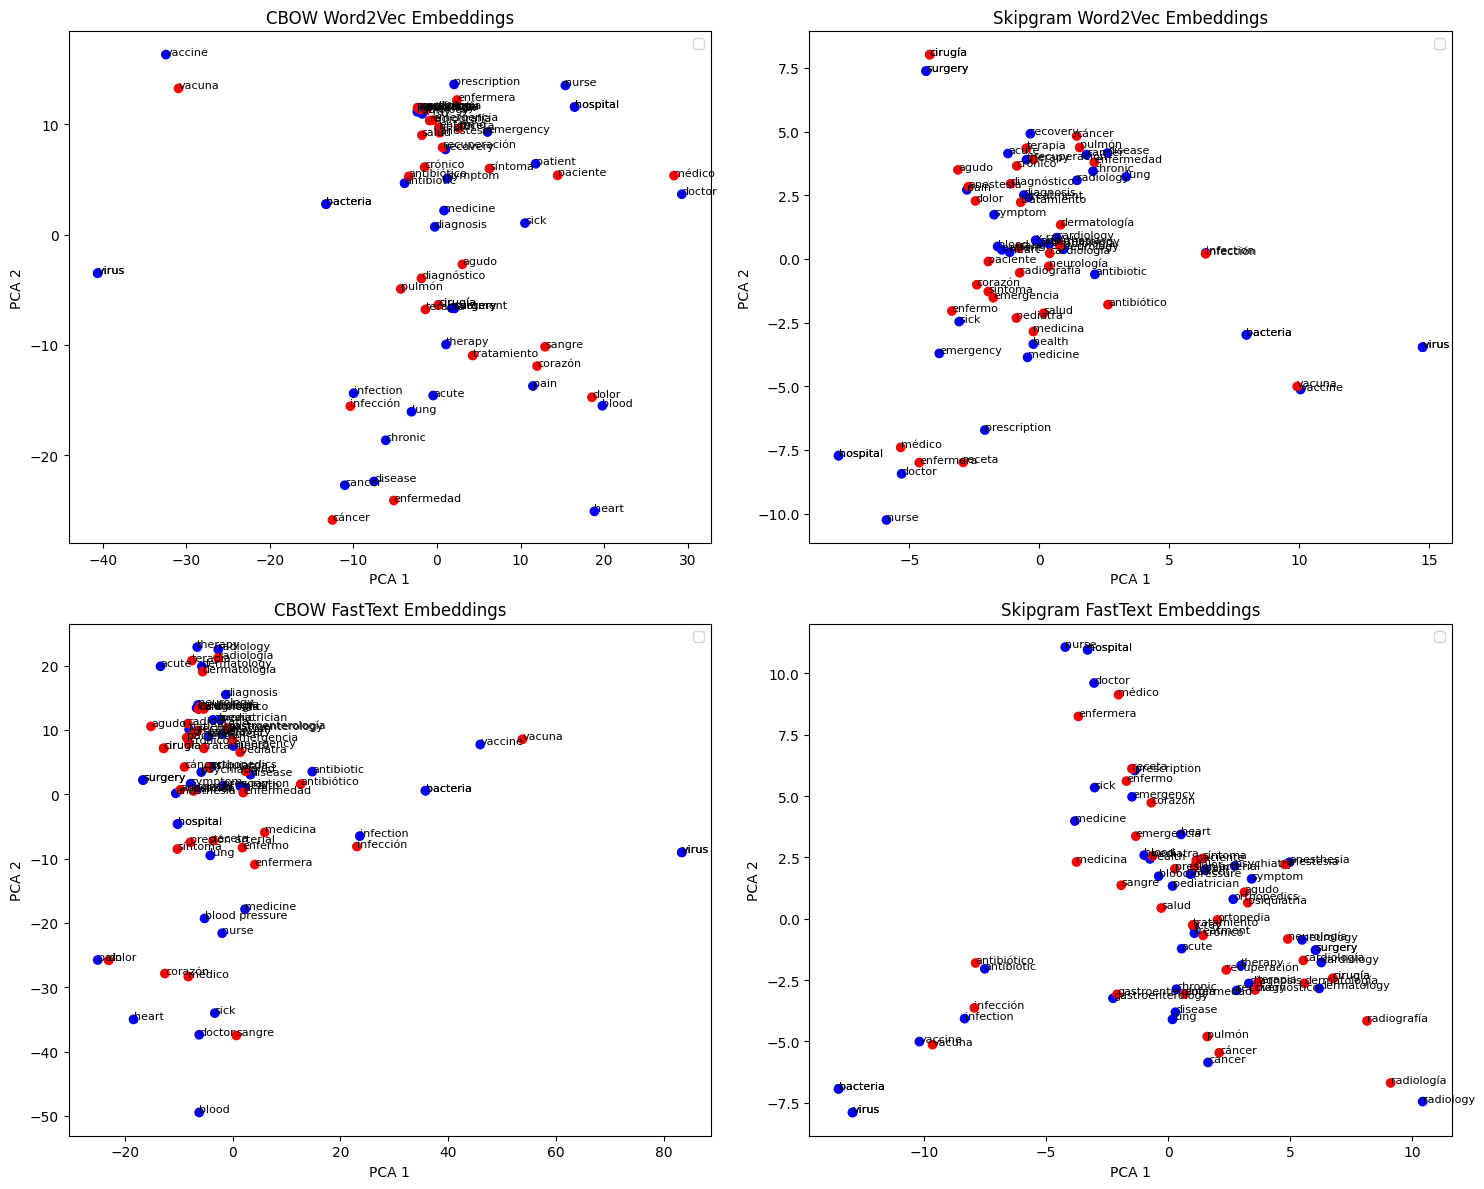

In [ ]:
# Medical words in English and Spanish
english_words = [
    "doctor", "hospital", "patient", "nurse", "surgery", "medicine", "treatment", "disease", "infection", "vaccine",
    "virus", "bacteria", "health", "heart", "lung", "blood", "cancer", "antibiotic", "diagnosis", "symptom",
    "pain", "sick", "prescription", "emergency", "chronic", "acute", "recovery", "blood pressure", "x-ray",
    "surgery", "anesthesia", "therapy", "radiology", "neurology", "cardiology", "orthopedics", "pediatrician",
    "gastroenterology", "dermatology", "psychiatry"
]

spanish_words = [
    "médico", "hospital", "paciente", "enfermera", "cirugía", "medicina", "tratamiento", "enfermedad", "infección",
    "vacuna", "virus", "bacterias", "salud", "corazón", "pulmón", "sangre", "cáncer", "antibiótico", "diagnóstico",
    "síntoma", "dolor", "enfermo", "receta", "emergencia", "crónico", "agudo", "recuperación", "presión arterial",
    "radiografía", "cirugía", "anestesia", "terapia", "radiología", "neurología", "cardiología", "ortopedia",
    "pediatra", "gastroenterología", "dermatología", "psiquiatría"
]

# Combine the lists of English and Spanish words
all_words = english_words + spanish_words

# Function to extract vectors for selected words
def get_selected_vectors(model, selected_words):
    # Filter out words not present in the model's vocabulary
    present_words = [word for word in selected_words if word in model.wv]
    vectors = [model.wv[word] for word in present_words]
    return present_words, vectors

# Function to reduce dimensions using PCA or t-SNE
def reduce_dimensions(vectors, method='pca'):
    if method == 'pca':
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(vectors)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        reduced = tsne.fit_transform(vectors)
    return reduced

# Function to plot the embeddings side by side with legend
def plot_embeddings_side_by_side(models, english_words, all_words, factor=4):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Create 2x2 grid for subplots

    for ax, (title, model) in zip(axes.flatten(), models):
        present_words, vectors = get_selected_vectors(model, all_words)
        reduced_vectors = reduce_dimensions(vectors, 'pca')  # Use PCA or t-SNE

        # Rescale for more separation
        rescaled_reduced = reduced_vectors * factor

        # Create color array: Blue for English, Red for Spanish
        colors = ['blue' if word in english_words else 'red' for word in present_words]

        # Scatter plot on the axis
        scatter = ax.scatter(rescaled_reduced[:, 0], rescaled_reduced[:, 1], c=colors, marker='o')

        # Annotate words
        for i, word in enumerate(present_words):
            ax.annotate(word, (rescaled_reduced[i, 0], rescaled_reduced[i, 1]), fontsize=8)

        ax.set_title(f'{title} Embeddings')
        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')

        # Add legend
        handles, labels = scatter.legend_elements()
        ax.legend(handles, ['English', 'Spanish'], loc='best')

    plt.tight_layout()
    plt.show()

# Models to plot
models = [
    ("CBOW Word2Vec", cbow_model),
    ("Skipgram Word2Vec", skipgram_model),
    ("CBOW FastText", cbow_ft),
    ("Skipgram FastText", skipgram_ft)
]

# Plot all models side by side
plot_embeddings_side_by_side(models, english_words, all_words, factor=4)

**Skipgram models outperform CBOW**: Across all types of embeddings, the Skipgram-based models (Word2Vec and FastText) perform better than the CBOW models, especially in terms of alignment between English and Spanish terms. This is likely because Skipgram is better at learning semantic relationships.

**FastText improves handling of out-of-vocabulary words:** The FastText models show more consistent performance with words that might have different forms in the two languages, like "doctor" and "médico". This is a result of FastText’s ability to break down words into smaller subword units.

